# Modelling

## Packages

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import winsound
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

from keras.utils import np_utils

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

from imblearn.over_sampling import SMOTE

from matplotlib import pyplot as plt

print(f" Found and Using {len(tf.config.experimental.list_physical_devices('GPU'))} GPU")

 Found and Using 1 GPU


## Functions

In [2]:
def scale_x_encode_y(x, y):

    x_scaled = StandardScaler().fit_transform(x.values)    
    
    encoder = LabelEncoder()
    encoder.fit(y)
    y_encoded = encoder.transform(y)
    y_encoded = np_utils.to_categorical(y_encoded)
    
    y_map = dict(zip(encoder.transform(encoder.classes_),encoder.classes_))
 
    return(x_scaled, y_encoded, y_map)

def smote_data(x, y):
    oversample = SMOTE()
    smote_x, smote_y = oversample.fit_resample(x, y)

    return(smote_x, smote_y)

def split_data(df, divisor):
    df_tot = df.copy()
    print(f'df_tot count : {len(df_tot)}')

    df1 = df_tot.iloc[int(len(df_tot)/divisor):]
    print(f'df1 count : {len(df1)}')

    df2 = df_tot.iloc[:int(len(df_tot)/divisor)]
    print(f'df2 count : {len(df2)}')
    
    return(df_tot, df1, df2)

def data_prep(df, apply_smote = False):
    x = df.loc[:, df.columns != target_col]
    y = df[target_col]

    if apply_smote:
        x, y = smote_data(x, y)

    print(f'Record count : {len(y)}')
    print('--------------------------')
    print(y.value_counts())
    print('--------------------------')
    print(y.value_counts(normalize=True))
    
    x_scaled, y_encoded, y_map = scale_x_encode_y(x, y)
    pd.DataFrame(x_scaled).head()
    
    return(x_scaled, y_encoded, y_map)

## Read Data

In [6]:
#df = pd.read_csv('data/tab_df.csv')
df = pd.read_csv('data/tab_M1_2019.csv')

#df = df[['diff', 'avg_gain', 'avg_loss', 'rs', 'rsi', 'slope', 'target']]
df.head(5)

,Open,High,Low,Close,diff,gain,loss,avg_gain,avg_loss,rs,rsi,ssma,lsma,sma_diff,sema,lema,ema_diff,slope_s,target
0,1.14541,1.14544,1.14541,1.14541,0.00009,0.00009,0.00000,0.000038,0.000060,0.633333,38.775510,1.145300,1.146044,-0.000744,1.145337,1.145868,-0.000531,-52.366769,same
1,1.14546,1.14549,1.14546,1.14547,0.00006,0.00006,0.00000,0.000044,0.000048,0.916667,47.826087,1.145296,1.146039,-0.000743,1.145361,1.145859,-0.000498,45.855097,same
2,1.14543,1.14543,1.14541,1.14541,-0.00006,0.00000,0.00006,0.000044,0.000045,0.977778,49.438202,1.145295,1.146032,-0.000737,1.145370,1.145849,-0.000479,68.029719,same
3,1.14532,1.14537,1.14532,1.14533,-0.00008,0.00000,0.00008,0.000044,0.000038,1.157895,53.658537,1.145301,1.146019,-0.000718,1.145363,1.145837,-0.000474,68.222514,same
4,1.14531,1.14531,1.14525,1.14526,-0.00007,0.00000,0.00007,0.000036,0.000045,0.800000,44.444444,1.145292,1.146011,-0.000719,1.145344,1.145824,-0.000480,69.007147,same


In [7]:
target_col = 'target'

print(f'Record count : {len(df)}')
print('--------------------------')
print(df[target_col].value_counts())
print('--------------------------')
print(df[target_col].value_counts(normalize=True))

Record count : 186166
--------------------------
same        180365
decrease      2991
increase      2810
Name: target, dtype: int64
--------------------------
same        0.968840
decrease    0.016066
increase    0.015094
Name: target, dtype: float64


print('Data split')
df_tot, df1, df2 = split_data(df, 5)
print('----------------------------------------------------')
print('Scale encode train valid data')
x_scaled, y_encoded, y_map = data_prep(df, apply_smote = False)
print('----------------------------------------------------')
print('Scale encode test data')
x_scaled1, y_encoded1, y_map1 = data_prep(df2, apply_smote = False)

In [ ]:
x_scaled, y_encoded, y_map = data_prep(df, apply_smote = False)

## Train test split

In [9]:
train_x, valid_x, train_y, valid_y = train_test_split(x_scaled, y_encoded,train_size = 0.8,random_state = 1)

## Neural Network

### Network building

In [10]:
model = Sequential([
    Dense(units = 16, activation='relu', input_shape=[len(train_x[0])]),
    Dense(units = 32, activation='relu'),
    #Dense(units = 64, activation='relu'),
    #Dense(units = 32, activation='relu'),
    #Dense(units = 16, activation='relu'),
    Dense(units = 3, activation='softmax')
])

In [11]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),    
    metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                304       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total params: 947
Trainable params: 947
Non-trainable params: 0
_________________________________________________________________


### Parameters

In [13]:
epoch_val         = 10
batch_size_val    = 64

verbose_val       = 2
workers_val       = -1

### Training

In [14]:
model.fit(x=train_x, 
          y=train_y, 
          epochs=epoch_val,
          batch_size = batch_size_val,
          validation_data = (valid_x, valid_y),
          workers= workers_val,
         verbose=verbose_val)

Epoch 1/10
2328/2328 - 4s - loss: 0.0926 - accuracy: 0.9734 - val_loss: 0.0531 - val_accuracy: 0.9812
Epoch 2/10
2328/2328 - 4s - loss: 0.0519 - accuracy: 0.9813 - val_loss: 0.0522 - val_accuracy: 0.9813
Epoch 3/10
2328/2328 - 4s - loss: 0.0509 - accuracy: 0.9815 - val_loss: 0.0520 - val_accuracy: 0.9813
Epoch 4/10
2328/2328 - 4s - loss: 0.0507 - accuracy: 0.9816 - val_loss: 0.0503 - val_accuracy: 0.9821
Epoch 5/10
2328/2328 - 4s - loss: 0.0503 - accuracy: 0.9815 - val_loss: 0.0504 - val_accuracy: 0.9819
Epoch 6/10
2328/2328 - 4s - loss: 0.0503 - accuracy: 0.9815 - val_loss: 0.0501 - val_accuracy: 0.9823
Epoch 7/10
2328/2328 - 4s - loss: 0.0498 - accuracy: 0.9817 - val_loss: 0.0502 - val_accuracy: 0.9817
Epoch 8/10
2328/2328 - 4s - loss: 0.0497 - accuracy: 0.9814 - val_loss: 0.0494 - val_accuracy: 0.9818
Epoch 9/10
2328/2328 - 4s - loss: 0.0496 - accuracy: 0.9814 - val_loss: 0.0491 - val_accuracy: 0.9819
Epoch 10/10
2328/2328 - 4s - loss: 0.0493 - accuracy: 0.9818 - val_loss: 0.0490 - 

### DNN Validation

In [19]:
predictions = model.predict(valid_x)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(valid_y, axis = -1)

print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map.values()))

              precision    recall  f1-score   support

    decrease       0.73      0.64      0.68       622
    increase       0.78      0.60      0.68       532
        same       0.99      0.99      0.99     36080

    accuracy                           0.98     37234
   macro avg       0.83      0.74      0.78     37234
weighted avg       0.98      0.98      0.98     37234



### DNN Prediction

In [16]:
df1 = pd.read_csv('data/tab_M1_2018.csv')
x_scaled1, y_encoded1, y_map1 = data_prep(df1, apply_smote = False)

predictions = model.predict(x_scaled1)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(y_encoded1, axis = -1)

df1['predictions'] = [y_map1[k] for k in rounded_predictions]
df1.to_csv('data/tab_M1_2018_res.csv')

print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map1.values()))

Record count : 186205
--------------------------
same        168535
decrease      9137
increase      8533
Name: target, dtype: int64
--------------------------
same        0.905105
decrease    0.049070
increase    0.045826
Name: target, dtype: float64
              precision    recall  f1-score   support

    decrease       0.93      0.31      0.47      9137
    increase       0.95      0.25      0.40      8533
        same       0.93      1.00      0.96    168535

    accuracy                           0.93    186205
   macro avg       0.93      0.52      0.61    186205
weighted avg       0.93      0.93      0.91    186205



## RF Results

In [17]:
%%time
clf = RandomForestClassifier() 
clf.fit(train_x, train_y)
predictions = clf.predict(valid_x)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(valid_y, axis = -1)
print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map.values()))

              precision    recall  f1-score   support

    decrease       0.76      0.60      0.67       622
    increase       0.79      0.65      0.71       532
        same       0.99      0.99      0.99     36080

    accuracy                           0.98     37234
   macro avg       0.85      0.75      0.79     37234
weighted avg       0.98      0.98      0.98     37234

Wall time: 1min 12s


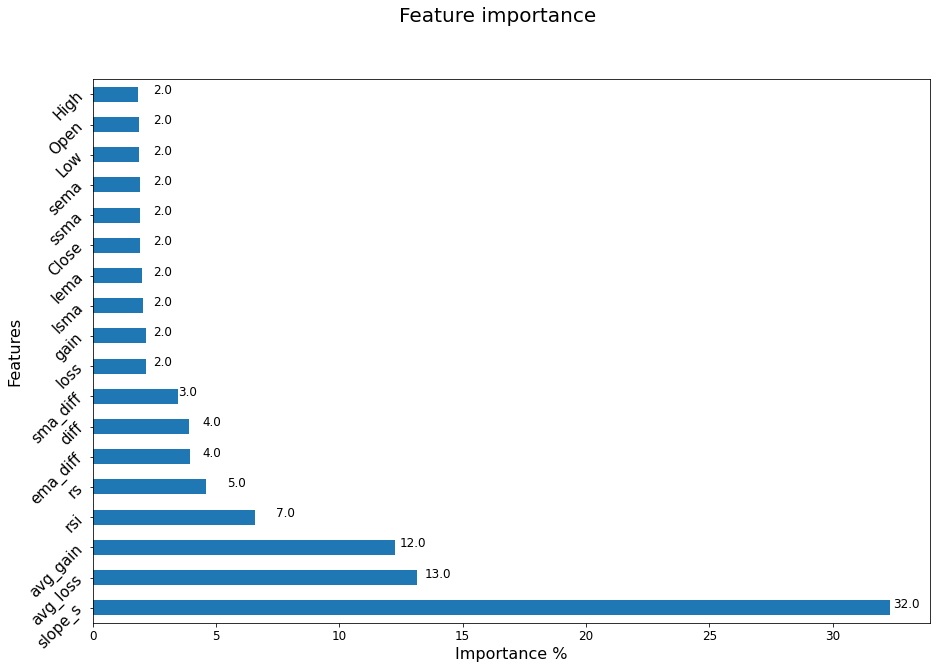

In [18]:
x_cols = df.columns[df.columns != 'target']
fig = plt.figure()
fig.suptitle('Feature importance', fontsize=20)
plt.xlabel('Importance %', fontsize=16)
plt.ylabel('Features', fontsize=16)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=15)


feat_importances = pd.Series(clf.feature_importances_ * 100, index=x_cols)
feat_importances.nlargest(25).plot(kind='barh', figsize=(15, 10), rot=45)

for index, value in enumerate(np.round(-np.sort(-clf.feature_importances_ * 100))):
    plt.text(value+0.45, index, str(value), fontsize=12)